<h2>STINTSY Machine Project</h2>

Group Doc OCT (Patrick Ong, Russel Campol, Miko Tansingco)

<h4>Library Importing</h4>

In [26]:
import matplotlib.image as mpimg
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from random import *

<h4>Exploratory Data Analysis</h4>

1. Analysis of images

In [2]:
def loadDataFromFolder(folder):
    images = []
    for filename in os.listdir(folder):
        img = mpimg.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [3]:
images = loadDataFromFolder('train')

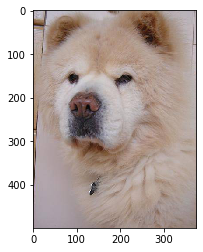

In [21]:
ind = randint(0,len(images))
plt.imshow(images[ind])

2. Analysis of labels

In [28]:
labels = pd.read_csv('labels.csv')
labels

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [100]:
breed_count = labels.groupby('breed').count().sort_values('id')
breed_count

,id
breed,
briard,66
eskimo_dog,66
komondor,67
brabancon_griffon,67
golden_retriever,67
...,...
bernese_mountain_dog,114
entlebucher,115
afghan_hound,116


In [111]:
breed_count.describe()

,id
count,120.000000
mean,85.183333
std,13.298122
min,66.000000
25%,75.000000
50%,82.000000
75%,91.250000
max,126.000000
